<a href="https://colab.research.google.com/github/Kumar0510/movie-recommendation-ml/blob/main/ml_movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505175 sha256=b4d0ed9a717a2e7f572d336c11b7b4038d66e0dd99e7d32d6742ddd9e62bcfc0
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

In [ ]:
md = pd. read_csv('/content/drive/MyDrive/ml movie recommender/movies_metadata.csv')
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [ ]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

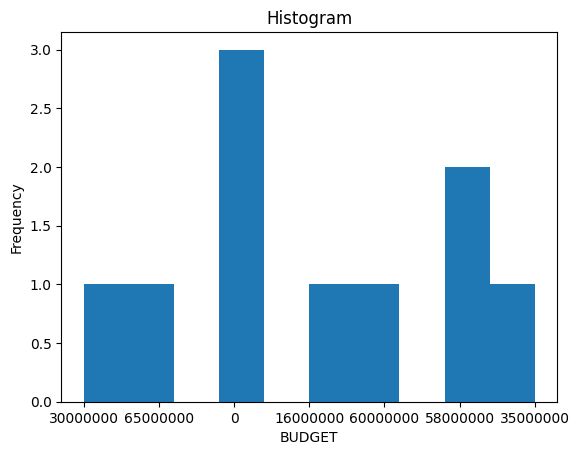

In [ ]:
# Histogram with Matplotlib
sliced_data = md.head(10)
plt.hist(sliced_data['budget'])
plt.xlabel('BUDGET')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

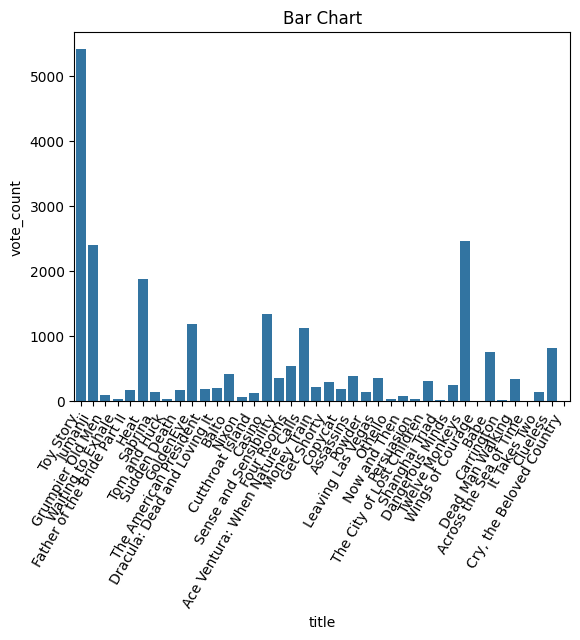

In [ ]:
# Bar chart with Seaborn
sliced_data = md.head(40)  # Select the first 90 rows
sns.barplot(x='title', y='vote_count', data=sliced_data)

plt.title('Bar Chart')
plt.xticks(rotation=60, ha='right')
plt.show()

In [ ]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [ ]:
m = vote_counts.quantile(0.95)
m

434.0

In [ ]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape


(2274, 6)

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [ ]:
qualified.head(15)


,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [ ]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [ ]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

In [ ]:
build_chart('Comedy').head(10)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.463024
351,Forrest Gump,1994,8147,8,48.307194,7.963363
1225,Back to the Future,1985,6239,8,25.778509,7.952358
18465,The Intouchables,2011,5410,8,16.086919,7.945207
22841,The Grand Budapest Hotel,2014,4644,8,14.442048,7.936384
2211,Life Is Beautiful,1997,3643,8,39.39497,7.919430
732,Dr. Strangelove or: How I Learned to Stop Worr...,1964,1472,8,9.80398,7.809073
3342,Modern Times,1936,881,8,8.159556,7.695554
883,Some Like It Hot,1959,835,8,11.845107,7.680781
1236,The Great Dictator,1940,756,8,9.241748,7.651762


In [ ]:
links_small = pd.read_csv('/content/drive/MyDrive/ml movie recommender/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')


In [ ]:
md = md.drop([19730, 29503, 35587])


In [ ]:
md['id'] = md['id'].astype('int')


In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')


In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])


In [ ]:
tfidf_matrix.shape

(9099, 268124)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim


array([[1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
        0.        ],
       [0.00680476, 1.        , 0.01531062, ..., 0.00357057, 0.00762326,
        0.        ],
       [0.        , 0.01531062, 1.        , ..., 0.        , 0.00286535,
        0.00472155],
       ...,
       [0.        , 0.00357057, 0.        , ..., 1.        , 0.07811616,
        0.        ],
       [0.00344913, 0.00762326, 0.00286535, ..., 0.07811616, 1.        ,
        0.        ],
       [0.        , 0.        , 0.00472155, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

nan


In [ ]:
get_recommendations('The Godfather').head(10)


,title
973,The Godfather: Part II
8387,The Family
3509,Made
4196,Johnny Dangerously
29,Shanghai Triad
5667,Fury
2412,American Movie
1582,The Godfather: Part III
4221,8 Women
2159,Summer of Sam


In [ ]:
get_recommendations('The Dark Knight').head(10)


,title
7931,The Dark Knight Rises
132,Batman Forever
1113,Batman Returns
8227,"Batman: The Dark Knight Returns, Part 2"
7565,Batman: Under the Red Hood
524,Batman
7901,Batman: Year One
2579,Batman: Mask of the Phantasm
2696,JFK
8165,"Batman: The Dark Knight Returns, Part 1"


## COLABORATIVE FILTERING

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/ml movie recommender/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


TEST PHASE

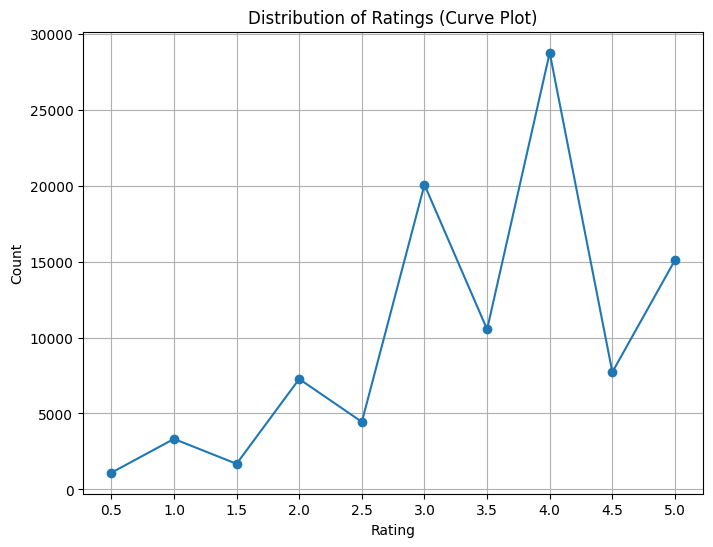

RMSE: 0.8881
RMSE: 0.8880645426350304


In [ ]:
import pandas as pd
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

# Load the ratings data
ratings = pd.read_csv('/content/drive/MyDrive/ml movie recommender/ratings_small.csv')

# Assuming you've already loaded 'ratings'
rating_counts = ratings['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.plot(rating_counts.index, rating_counts.values, marker='o', linestyle='-')
plt.title('Distribution of Ratings (Curve Plot)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rating_counts.index)  # Set x-axis ticks to rating values
plt.grid(True)  # Add a grid for better readability
plt.show()
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the data into Surprise format
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=.20)

# Train the SVD model
model = SVD()
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model using RMSE
rmse = accuracy.rmse(predictions)

# Print the RMSE
print(f'RMSE: {rmse}')




In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def get_collab_recs(user_id, relevant_movies,top_n=5):
    # Get a list of all movie IDs
    all_movie_ids = ratings['movieId'].unique()

    # Get a list of movie IDs that the user has already rated
    rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].values

    # Get a list of movie IDs that the user has not rated
    unrated_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids]

    # Predict the ratings for the unrated movies
    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]

    # Sort the predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get the top_n movie IDs from the predictions
    top_movie_ids = [prediction.iid for prediction in predictions[:top_n]]

    movie_titles = []
    for movie_id in top_movie_ids:
        movie_row = md[md['id'] == movie_id]  # Get the row corresponding to movie_id
        if not movie_row.empty:  # Check if the row is not empty
            movie_title = movie_row['title'].values[0]
            movie_titles.append(movie_title)

    movie_titles = set(movie_titles)  # Convert to a set for efficient comparison
    print(movie_titles)
    #print(relevant_movies)
    true_positives = len(movie_titles.intersection(relevant_movies))  # Count true positives
    accuracy = true_positives / top_n  # Calculate accuracy
    y_pred = [1 if movie in movie_titles else 0 for movie in relevant_movies]  # Predictions
    y_true = [1] * len(relevant_movies)  # True labels (all relevant)
    report = classification_report(y_true, y_pred)
    print("Clasification report for Collaborative Filtering Recommendations")
    print(report)
    return accuracy

In [ ]:
get_collab_recs(1,['The Thomas Crown Affair', 'Sleepless in Seattle', 'The Good Thief', 'Hard Target', 'Galaxy Quest', 'The Return of the King'])

{'Hard Target', 'Sleepless in Seattle', 'The Thomas Crown Affair', 'Galaxy Quest'}
Clasification report for Collaborative Filtering Recommendations
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80         6

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6



0.8

# **HYBRID model**

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

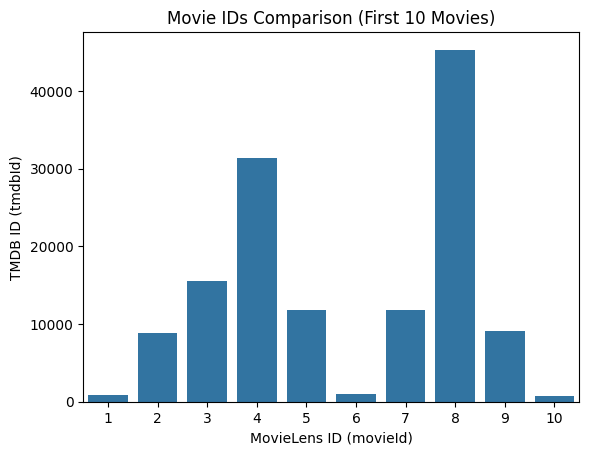

In [ ]:
id_map = pd.read_csv('/content/drive/MyDrive/ml movie recommender/links_small.csv')[['movieId', 'tmdbId']]
import matplotlib.pyplot as plt
import seaborn as sns

sliced_data = id_map.head(10)  # Select the first 10 rows for a manageable plot
sns.barplot(x='movieId', y='tmdbId', data=sliced_data)
plt.title('Movie IDs Comparison (First 10 Movies)')
plt.xlabel('MovieLens ID (movieId)')
plt.ylabel('TMDB ID (tmdbId)')
plt.show()

In [ ]:
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
The Last Brickmaker in America,161944,159550.0
Rustom,162542,392572.0
Mohenjo Daro,162672,402672.0


In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
from surprise import Reader, Dataset, SVD, accuracy

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    # Fix: Provide uid and iid explicitly
    movies['est'] = movies['id'].apply(lambda x: model.predict(uid=userId, iid=indices_map.loc[x]['movieId']).est)  # Use model instance
    movies = movies.sort_values('est', ascending=False)

    return movies.head(10)

In [ ]:
hybrid(1, 'The Matrix')

,title,vote_count,vote_average,year,id,est
937,The English Patient,559.0,7.0,1996,409,3.128251
5330,Gladiator 1992,28.0,5.7,1992,16219,3.125634
6320,District B13,572.0,6.5,2004,10045,3.036517
1518,Out of Africa,290.0,7.0,1985,606,2.979432
6671,Benny's Video,67.0,7.1,1993,1987,2.972182
1130,Sneakers,301.0,6.7,1992,2322,2.963701
4097,The Believer,152.0,6.8,2001,4012,2.947068
7941,The Girl with the Dragon Tattoo,2479.0,7.2,2011,65754,2.923495
3114,The Specials,11.0,5.5,2000,29015,2.879264
5911,The Animatrix,433.0,6.9,2003,55931,2.862813


In [ ]:
["The Matrix", "A Grand Day Out" , "A Trip to the Moon", "The Dish" ,
 "The Hidden", "A Simple Plan", "Green Zone", "Hanna	", "Rocketship X-M", "Dog Soldiers"]

# **Evaluation of Models**

Content based Model,
Colaboratve Filtering Model,
Hybrid Model,

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate_content_based(user_id, title, relevant_movies, k=10):
    recommended_movies = get_recommendations(title).head(k).values
    recommended_movies = set([movie.strip().lower() for movie in recommended_movies])
    relevant_movies = set([movie.strip().lower() for movie in relevant_movies])
    true_positives = len(recommended_movies.intersection(relevant_movies))
    precision = true_positives / len(recommended_movies) if recommended_movies else 0
    recall = true_positives / len(relevant_movies) if relevant_movies else 0
    #print(f"\nPrecision@{k}: {precision:.4f}")
    #print(f"Recall@{k}: {recall:.4f}")
    accuracy = true_positives / k  # Accuracy = True Positives / Total Recommendations
    #print(f"Accuracy@{k}: {accuracy:.4f}")  # Print accuracy

    # Generate predicted labels (1 for recommended, 0 for not recommended)
    y_pred = [1 if movie.strip().lower() in recommended_movies else 0 for movie in relevant_movies]
    y_true = [1] * len(relevant_movies)
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    print("Clasification report for Content based Recommendations")
    print(report)
    return accuracy


In [ ]:
def evaluate_collab_based(user_id, title, relevant_movies, k=10):
    recommended_movies = get_collab_recs(title).head(k).values
    recommended_movies = set([movie.strip().lower() for movie in recommended_movies])
    relevant_movies = set([movie.strip().lower() for movie in relevant_movies])
    true_positives = len(recommended_movies.intersection(relevant_movies))
    precision = true_positives / len(recommended_movies) if recommended_movies else 0
    recall = true_positives / len(relevant_movies) if relevant_movies else 0
    #print(f"\nPrecision@{k}: {precision:.4f}")
    #print(f"Recall@{k}: {recall:.4f}")
    accuracy = true_positives / k  # Accuracy = True Positives / Total Recommendations
    #print(f"Accuracy@{k}: {accuracy:.4f}")  # Print accuracy

    # Generate predicted labels (1 for recommended, 0 for not recommended)
    y_pred = [1 if movie.strip().lower() in recommended_movies else 0 for movie in relevant_movies]
    y_true = [1] * len(relevant_movies)
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    print("Clasification report for Content based Recommendations")
    print(report)
    return accuracy

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def evaluate_hybrid_model(user_id, movie_title, relevant_movies, k=10):

    # Get recommendations from the hybrid model
    recommended_movies = hybrid(user_id, movie_title)['title'].tolist()
    recommended_movies = recommended_movies[:k] # Get top k recommendations

    # Convert movie titles to lowercase for case-insensitive comparison
    """
    recommended_movies = set(map(str.lower, recommended_movies))
    relevant_movies = set(map(str.lower, relevant_movies))
    """
    # Calculate metrics
    recommended_movies = set(recommended_movies)
    #print(recommended_movies)
    true_positives = len(recommended_movies.intersection(relevant_movies))
    precision = true_positives / len(recommended_movies) if recommended_movies else 0
    recall = true_positives / len(relevant_movies) if relevant_movies else 0
    accuracy = true_positives / k  # Accuracy = True Positives / Total Recommendations
    # Store predicted and true labels for confusion matrix
    predicted_labels = []
    true_labels = []

    for movie in recommended_movies:
        predicted_labels.append(1)  # 1 for recommended

    for movie in relevant_movies:  # Assuming you have a list of all movies
        if movie in relevant_movies:
            true_labels.append(1)  # 1 for relevant
        else:
            true_labels.append(0)  # 0 for not relevant
    y_pred = [1 if movie in recommended_movies else 0 for movie in relevant_movies]
    y_true = [1] * len(relevant_movies)  # Assuming all movies in relevant_movies are relevant

    # Generate and print the classification report
    report = classification_report(y_true, y_pred)
    print("Classification Report for Hybrid Model:")
    print(report)
    return accuracy


In [ ]:
# Assuming you have defined evaluate_content_based, evaluate_collaborative_filtering, and evaluate_hybrid_model functions

# Calculate accuracy for Content-Based model
user_id = 1
movie_title = "Avatar"
content_based_accuracy = evaluate_content_based(user_id, movie_title,  ['The Matrix','Tears of the Sun',
 'Lara Croft Tomb Raider: The Cradle of Life',
 'Pandora and the Flying Dutchman', 'Hellraiser' ,'Green Zone'
 'The American', 'House Party 2', 'A Grand Day Out'], k=10)
# Do the same for the other evaluation functions
collab_accuracy = get_collab_recs(1,['Target', 'Sleepless in Seattle', 'The Thomas Crown Affair', 'Galaxy Quest'])
rel_movies = ["The Matrix", "A Grand Day Out" , "A Trip to the Moon", "The Dish" ,
 "The Hidden", "A Simple Plan", "Green Zone", "Hanna	", "Rocketship X-M", "Dog Soldiers"]
# Calculate accuracy for Hybrid model
hybrid_accuracy = (evaluate_hybrid_model(user_id, movie_title,rel_movies, k=10))


# Store the accuracy values in a list
accuracy_values = [content_based_accuracy, collab_accuracy,hybrid_accuracy]

Clasification report for Content based Recommendations
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.86         8

    accuracy                           0.75         8
   macro avg       0.50      0.38      0.43         8
weighted avg       1.00      0.75      0.86         8

{'Hard Target', 'Sleepless in Seattle', 'The Thomas Crown Affair', 'Galaxy Quest'}
Clasification report for Collaborative Filtering Recommendations
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.86         4

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4

Classification Report for Hybrid Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     

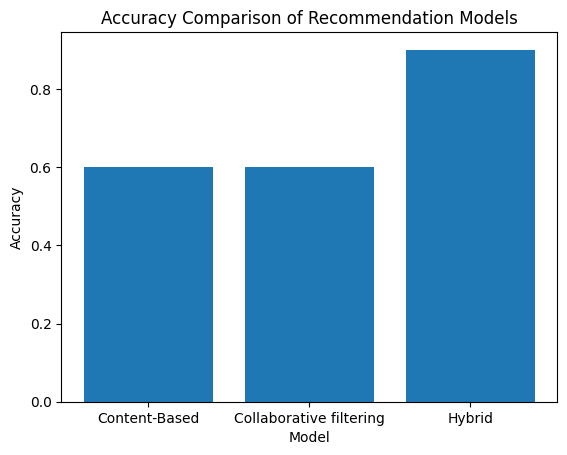

In [ ]:
import matplotlib.pyplot as plt

# Define model names
model_names = ['Content-Based','Collaborative filtering', 'Hybrid']

# Create the bar chart
plt.bar(model_names, accuracy_values)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Recommendation Models')

# Display the chart
plt.show()